# Búsqueda Tabú

Se implementará la versión de BT utilizando una lista de movimientos tabú y tres estrategias de reinicialización.Sus principales características son:
* Estrategia de selección de vecino: Consistirá en examinar 40 vecinos para cogerel mejor de acuerdo a los criterios tabú.
* Selección  de  estrategias  de reinicialización:  La  probabilidad  de  escoger  lareinicialización construyendo una solución inicial aleatoria es 0,25, la de usar lamemoria a largo plazo al generar una nueva solución greedy es 0,5, y la deutilizar la reinicialización desde la mejor solución obtenidaes 0,25.
* Además de saltar a una solución concreta según las reinicializaciones comentadas, también  se  alterará  un  parámetro  del  algoritmo  de  búsqueda  para  provocar  un cambio de comportamiento del algoritmo más efectivo. Este consistirá en variar el tamaño de la lista tabú, incrementándola o reduciéndola en un 50% según una decisión aleatoria uniforme. 
 
El número máximo de iteraciones en total, incluyendo las reinicializaciones, será de 40 · n. Se realizarán 4 reinicializaciones, es decir, una cada 8 · n iteraciones.  

El tamaño inicial   de   cada   lista   tabú   será n=2,   estos   valores   cambiarán   después   de   las reinicializaciones según se ha comentado.Dado el carácter probabilístico del algoritmo, deberá ejecutarse 10 veces (con semillas distintas para el generador aleatorio, para cada caso del problema (dataset).

---
## Librerías
- matplotlib: necesaria para la representación de la solución.
- pandas: necesaria para la representación de resultados.
- random: necesaria para el control de números aleatorios.
- datetime: necesaria para la obtención de una semilla inicial que genere las demás semillas.
- multiprocessing: necesaria para la ejecución concurrente de las soluciones.
- itertools: necesaria para combinar las semillas con los dataset en la ejecución concurrente.
- ipynb: necesaria para cargar la función busqueda_aleatorio de otro fichero. Esto permite la ejecución concurrente en Jupyter.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from random import seed
from random import randint
from datetime import datetime
from multiprocessing import Pool, TimeoutError
import itertools
from ipynb.fs.full.algoritmo import busqueda_tabu

---
## Funciones auxiliares
- cargar_fichero(nombre_fichero): devuelve un array con las ciudades almacenadas en el fichero. [ [ ciudad, posición x , posición y ] [...] ... ]
- calcular_distancia_euclidea(node_1,node_2): devuelve en la distancia entre las dos ciudades.
- dibujar_flecha(A, B): dibuja una flecha entre el punto A y B apuntando a B. 
- representacion(camino, nombre, distancia): representa las ciudades y el camino calculado.
- representacion_datos(result,nombre): representa la solución obtenida de la ejecución concurrente de un dataset.
- agregar_resultados(dataframe,nombre,result): guarda los resultados de la ejecución en el dataframe según la plantilla del pdf.

In [2]:
def cargar_fichero(nombre_fichero):
    
    fichero = open( "../Dataset/" + nombre_fichero + ".tsp", 'r')
    
    for i in range(3):
        fichero.readline()
        
    numero_de_ciudades = fichero.readline().strip().split()[1]
    
    for i in range(2):
        fichero.readline()
        
    ciudades = []
    for i in range(0, int(numero_de_ciudades)):
        ciudad,x,y = fichero.readline().strip().split()[:]
        ciudades.append([int(ciudad),float(x),float(y)])  
        
    fichero.close()
    
    return ciudades

In [3]:
def calcular_distancia_euclidea(ciudad_1,ciudad_2):
    
    x1,y1 = ciudad_1[1 :]
    x2,y2 = ciudad_2[1 :]
    
    xd = x1 - x2
    yd = y1 - y2
    
    return round(math.sqrt( xd*xd + yd*yd ))

In [4]:
def dibujar_flecha(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=1.3, length_includes_head=True)

In [5]:
def representacion(camino, nombre, distancia):
    
    plt.figure(figsize=(10,10))
    
    for i in range(len(camino)):
        if(i == 0):
            plt.plot(camino[i][1], camino[i][2] , "o", color="green")
        else:
            plt.plot(camino[i][1], camino[i][2] , "*", color="red")
        
        if(i<len(camino)-1):
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[i+1][1], camino[i+1][2]])
        else:
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[0][1], camino[0][2]])
    
    plt.title(nombre + " : " + str(distancia))

In [6]:
def representacion_datos(result,nombre):
    semilla_coste = pd.DataFrame(columns=["Semilla","Coste","Nº de evaluaciones"])
    for i in range(10):


        semilla_coste.loc[len(semilla_coste)] = [semillas[i],result[i][1], result[i][2]]
    display(semilla_coste)

    print("Media coste: ", semilla_coste[['Coste']].mean()[0])
    print("Desviación típica coste: ", semilla_coste[['Coste']].std()[0])
    print("Media nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].mean()[0])
    print("Desviación típica nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].std()[0])


    print()
    print("Representación de la mejor solución: ")
    indice = semilla_coste[['Coste']].idxmin()[0]


    representacion(result[indice][0], nombre, result[indice][1])

In [7]:
def agregar_resultados(dataframe,nombre,result):

    for i in range(10):
        dataframe.loc["Ejecución "+str(i+1),(nombre,"Coste")] = result[i][1]

    dataframe.loc["Media",(nombre,"Coste")] = resultados.loc[:"Ejecución 10",(nombre,"Coste")].mean()
    dataframe.loc["Des. Tip. (s)",(nombre,"Coste")] = resultados.loc[:"Ejecución 10",(nombre,"Coste")].std()

    for i in range(10):
        dataframe.loc["Ejecución "+str(i+1),(nombre,"#Ev")] = result[i][2]

    dataframe.loc["Media",(nombre,"#Ev")] = resultados.loc[:"Ejecución 10",(nombre,"#Ev")].mean()
    dataframe.loc["Des. Tip. (s)",(nombre,"#Ev")] = resultados.loc[:"Ejecución 10",(nombre,"#Ev")].std()

---
## Función de evaluación
Esta función genera el coste total de la solución pasara por parámetro. Para ello recorre todas las ciudades de la solución sumando el coste entre ellas. 

In [8]:
def funcion_de_evaluacion(solucion):
    coste = 0
    for indice in range(len(solucion)-1):
        coste += calcular_distancia_euclidea(solucion[indice],solucion[indice+1])
    coste += calcular_distancia_euclidea(solucion[-1],solucion[0])
    return coste

---
## Lectura de ficheros y ejecución del algoritmo
Para poder ejecutar correctamente el algoritmo de forma concurrente en Jupyter, este debe ser cargado de forma externa. Para ello se ha usado la librería ipynb.

In [9]:
st70 = cargar_fichero("st70")
ch130 = cargar_fichero("ch130")
a280 = cargar_fichero("a280")
p654 = cargar_fichero("p654")
vm1084 = cargar_fichero("vm1084")
vm1748 = cargar_fichero("vm1748")

### Generación de semillas

In [10]:
semillas = []
dt = datetime.now()
for i in range(10):
    semillas.append(randint(0,dt.microsecond))
print("Semillas generadas:")
print(semillas)

Semillas generadas:
[245897, 182847, 187522, 278414, 273699, 75, 161624, 74213, 295533, 219639]


## Dataframe para ver los resultados

In [11]:
mux = pd.MultiIndex.from_product([["St70","Ch130","A280","Pa654","Vm1084","Vm1748"], ['Coste','#Ev']])
resultados = pd.DataFrame(
    columns=mux,
    index = ['Ejecución 1', 'Ejecución 2', 'Ejecución 3',"Ejecución 4","Ejecución 5","Ejecución 6","Ejecución 7","Ejecución 8","Ejecución 9","Ejecución 10","Media","Des. Tip. (s)"]
)

#### st70

,Semilla,Coste,Nº de evaluaciones
0,245897.0,936.0,112001.0
1,182847.0,1073.0,112001.0
2,187522.0,991.0,112001.0
3,278414.0,1011.0,112001.0
4,273699.0,1075.0,112001.0
5,75.0,1010.0,112001.0
6,161624.0,1017.0,112001.0
7,74213.0,1005.0,112001.0
8,295533.0,964.0,112001.0
9,219639.0,911.0,112001.0


Media coste:  999.3
Desviación típica coste:  52.5759767701308
Media nº de evaluaciones:  112001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


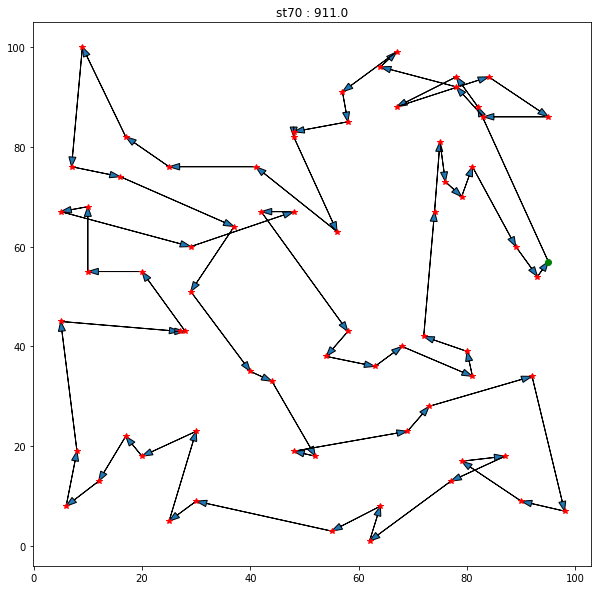

In [12]:
dataset = st70
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
representacion_datos(result,"st70")

agregar_resultados(resultados,"St70",result)

#### ch130


,Semilla,Coste,Nº de evaluaciones
0,245897.0,12708.0,208001.0
1,182847.0,12965.0,208001.0
2,187522.0,12399.0,208001.0
3,278414.0,12593.0,208001.0
4,273699.0,12612.0,208001.0
5,75.0,12412.0,208001.0
6,161624.0,12753.0,208001.0
7,74213.0,12313.0,208001.0
8,295533.0,11568.0,208001.0
9,219639.0,11981.0,208001.0


Media coste:  12430.4
Desviación típica coste:  406.49564709983196
Media nº de evaluaciones:  208001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


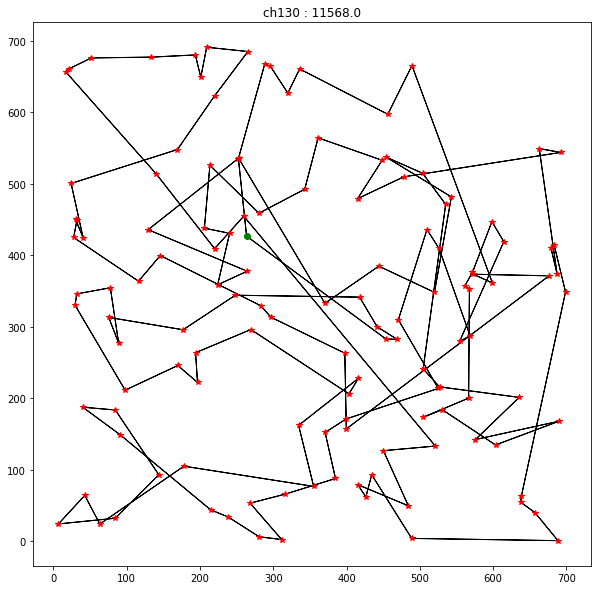

In [13]:
dataset = ch130

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"ch130")

agregar_resultados(resultados,"Ch130",result)

#### a280

,Semilla,Coste,Nº de evaluaciones
0,245897.0,4123.0,448001.0
1,182847.0,3462.0,448001.0
2,187522.0,3250.0,448001.0
3,278414.0,3218.0,448001.0
4,273699.0,2964.0,448001.0
5,75.0,3400.0,448001.0
6,161624.0,3224.0,448001.0
7,74213.0,3299.0,448001.0
8,295533.0,3183.0,448001.0
9,219639.0,3005.0,448001.0


Media coste:  3312.8
Desviación típica coste:  323.2724341274193
Media nº de evaluaciones:  448001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


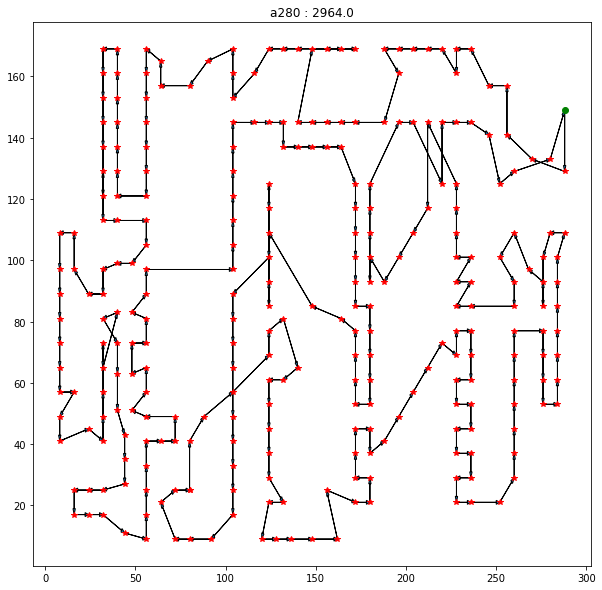

In [14]:
dataset = a280
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )

representacion_datos(result,"a280")

agregar_resultados(resultados,"A280",result)

#### p654

,Semilla,Coste,Nº de evaluaciones
0,245897.0,108566.0,1046401.0
1,182847.0,112408.0,1046401.0
2,187522.0,136613.0,1046401.0
3,278414.0,107542.0,1046401.0
4,273699.0,110473.0,1046401.0
5,75.0,114844.0,1046401.0
6,161624.0,108905.0,1046401.0
7,74213.0,119205.0,1046401.0
8,295533.0,300989.0,1046401.0
9,219639.0,108636.0,1046401.0


Media coste:  132818.1
Desviación típica coste:  59725.082399738516
Media nº de evaluaciones:  1046401.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


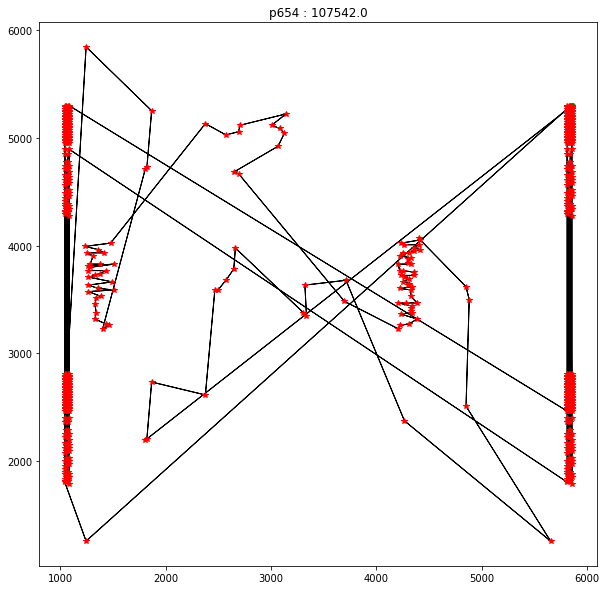

In [15]:
dataset = p654

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"p654")

agregar_resultados(resultados,"Pa654",result)

#### vm1084

,Semilla,Coste,Nº de evaluaciones
0,245897.0,1795905.0,1734401.0
1,182847.0,1918289.0,1734401.0
2,187522.0,1824882.0,1734401.0
3,278414.0,1819819.0,1734401.0
4,273699.0,1957831.0,1734401.0
5,75.0,1703828.0,1734401.0
6,161624.0,1759032.0,1734401.0
7,74213.0,1815570.0,1734401.0
8,295533.0,1739881.0,1734401.0
9,219639.0,1865098.0,1734401.0


Media coste:  1820013.5
Desviación típica coste:  78136.69307516298
Media nº de evaluaciones:  1734401.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


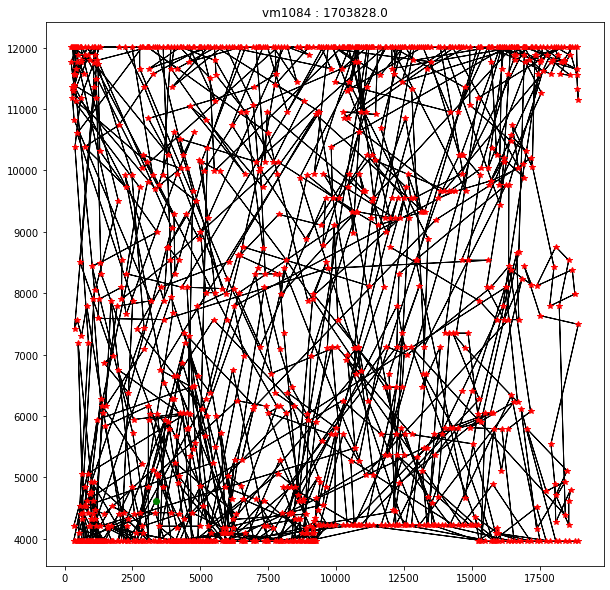

In [16]:
dataset = vm1084

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"vm1084")

agregar_resultados(resultados,"Vm1084",result)

#### vm1748

,Semilla,Coste,Nº de evaluaciones
0,245897.0,3235236.0,2796801.0
1,182847.0,3413694.0,2796801.0
2,187522.0,3272731.0,2796801.0
3,278414.0,3270034.0,2796801.0
4,273699.0,3133754.0,2796801.0
5,75.0,3278107.0,2796801.0
6,161624.0,3300488.0,2796801.0
7,74213.0,3198248.0,2796801.0
8,295533.0,3364568.0,2796801.0
9,219639.0,3393892.0,2796801.0


Media coste:  3286075.2
Desviación típica coste:  87100.66857735491
Media nº de evaluaciones:  2796801.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


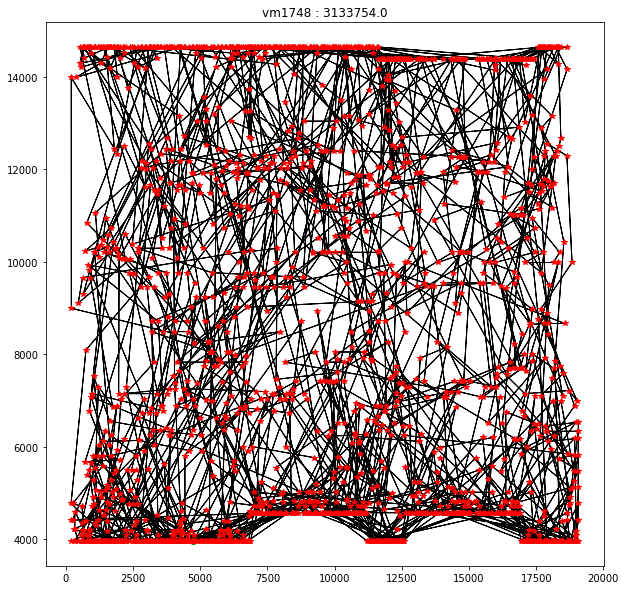

In [17]:
dataset = vm1748

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"vm1748")

agregar_resultados(resultados,"Vm1748",result)

---
# Resultados

In [18]:
resultados

St70                 Ch130                  A280  \
                   Coste       #Ev       Coste       #Ev       Coste   
Ejecución 1        936.0    112001     12708.0    208001      4123.0   
Ejecución 2       1073.0    112001     12965.0    208001      3462.0   
Ejecución 3        991.0    112001     12399.0    208001      3250.0   
Ejecución 4       1011.0    112001     12593.0    208001      3218.0   
Ejecución 5       1075.0    112001     12612.0    208001      2964.0   
Ejecución 6       1010.0    112001     12412.0    208001      3400.0   
Ejecución 7       1017.0    112001     12753.0    208001      3224.0   
Ejecución 8       1005.0    112001     12313.0    208001      3299.0   
Ejecución 9        964.0    112001     11568.0    208001      3183.0   
Ejecución 10       911.0    112001     11981.0    208001      3005.0   
Media              999.3  112001.0     12430.4  208001.0      3312.8   
Des. Tip. (s)  52.575977       0.0  406.495647       0.0  323.272434   

                              Pa654                   Vm1084             \
                    #Ev       Coste        #Ev         Coste        #Ev   
Ejecución 1      448001    108566.0    1046401     1795905.0    1734401   
Ejecución 2      448001    112408.0    1046401     1918289.0    1734401   
Ejecución 3      448001    136613.0    1046401     1824882.0    1734401   
Ejecución 4      448001    107542.0    1046401     1819819.0    1734401   
Ejecución 5      448001    110473.0    1046401     1957831.0    1734401   
Ejecución 6      448001    114844.0    1046401     1703828.0    1734401   
Ejecución 7      448001    108905.0    1046401     1759032.0    1734401   
Ejecución 8      448001    119205.0    1046401     1815570.0    1734401   
Ejecución 9      448001    300989.0    1046401     1739881.0    1734401   
Ejecución 10     448001    108636.0    1046401     1865098.0    1734401   
Media          448001.0    132818.1  1046401.0     1820013.5  1734401.0   
Des. Tip. (s)       0.0  59725.0824        0.0  78136.693075        0.0   

                     Vm1748             
                      Coste        #Ev  
Ejecución 1       3235236.0    2796801  
Ejecución 2       3413694.0    2796801  
Ejecución 3       3272731.0    2796801  
Ejecución 4       3270034.0    2796801  
Ejecución 5       3133754.0    2796801  
Ejecución 6       3278107.0    2796801  
Ejecución 7       3300488.0    2796801  
Ejecución 8       3198248.0    2796801  
Ejecución 9       3364568.0    2796801  
Ejecución 10      3393892.0    2796801  
Media             3286075.2  2796801.0  
Des. Tip. (s)  87100.668577        0.0

In [19]:
resultados.to_csv(r'./Resultados.csv')